# Image similarity search with clustering

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
from image_classification_simulation.data.office31_loader import Office31Loader
from image_classification_simulation.models.clustering_tools import show_grid_images
from image_classification_simulation.image_search import ImageSimilaritySearch
from image_classification_simulation.utils.visualization_utils import show_grid_images
from image_classification_simulation.models.clustering_tools import get_clustering_metrics

In [ ]:
import torch
from torchvision.utils import make_grid
from image_classification_simulation.models.clustering_tools import show_grid_images
def visualize_feature_space(data_loader,feature_dim,max_num_batches=10):
    features = []
    i=0
    for batch_img,batch_label in data_loader:
        # print(batch)
        z_x = image_search.model.extract_features(batch_img.cuda())
        features.append( z_x.cpu()) 
        if i>max_num_batches: break
        i+=1

    features = torch.stack(features,0).reshape(-1,feature_dim)
    grid = make_grid(features)
    plt.figure(figsize=(20, 30))
    plt.imshow(grid.permute(1, 2, 0))

In [31]:
hparams = {
    "num_workers": 2,
    'batch_size': 32,
    "image_size":224,
    "train_test_split":0.1,
}
office_loader = Office31Loader(data_dir="../examples/data/domain_adaptation_images/amazon/images/", hyper_params=hparams)
office_loader.setup('fit')
train_loader = office_loader.train_dataloader()
val_loader = office_loader.val_dataloader()
test_loader = office_loader.test_dataloader()
# /network/projects/aia/img_classif_sim/vit/output/best_model


In [69]:
hparams = {
        "clustering_alg": "MiniBatchKMeans",
        "loss": "CrossEntropyLoss",
        "batch_size": 124,
        "pretrained": True,
        "num_classes": 31,
        "path_to_model": "../examples/resnet/output/best_model/model.ckpt",
        "architecture": "resnet",
        "num_clusters": 31,
        "random_state": 0,
        "clustering_batch_size": 124,
        "size":256,
        "reassignment_ratio": 0.005,
        "path_cluster_ids": "../debug/dataset_cluster_ids.csv",
    }
image_search = ImageSimilaritySearch(hparams, office_loader)
image_search.setup()

[MiniBatchKMeans] Reassigning 8 cluster centers.
[MiniBatchKMeans] Reassigning 4 cluster centers.
[MiniBatchKMeans] Reassigning 6 cluster centers.
[MiniBatchKMeans] Reassigning 8 cluster centers.
>>> saved cluster ids to file
>>> setup completed successfully!


In [ ]:
from tqdm import tqdm
scores = []
for reassignment_ratio in tqdm([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]):
    hparams["reassignment_ratio"] = reassignment_ratio
    image_search = ImageSimilaritySearch(hparams, office_loader)
    image_search.setup()
    labels_true = np.array(image_search.dataset.class_label.to_list())
    labels_pred = image_search.dataset_cluster_ids
    m = get_clustering_metrics(labels_true, labels_pred)
    m["reassignment_ratio"] = reassignment_ratio
    scores.append(m)

In [77]:
resnet_score = pd.DataFrame(scores).sort_values(by="reassignment_ratio")
resnet_score

,rand_score,adjusted_rand_score,mutual_info_score,reassignment_ratio
12,0.087044,0.087044,1.071760,0.001
13,0.161435,0.161435,1.298566,0.005
0,0.162800,0.162800,1.370461,0.010
1,0.139031,0.139031,1.139910,0.050
2,0.045272,0.045272,0.621151,0.100
3,0.033729,0.033729,0.456634,0.200
4,0.007065,0.007065,0.419058,0.300
5,0.028539,0.028539,0.368802,0.400
6,0.034112,0.034112,0.453718,0.500
7,0.002285,0.002285,0.212037,0.600


<AxesSubplot:xlabel='reassignment_ratio'>

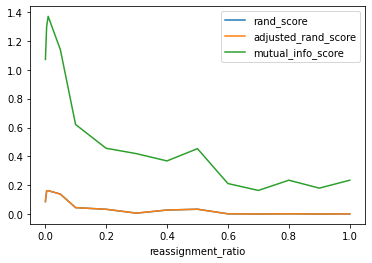

In [67]:
pd.DataFrame(scores).sort_values(by="reassignment_ratio").plot(x="reassignment_ratio")

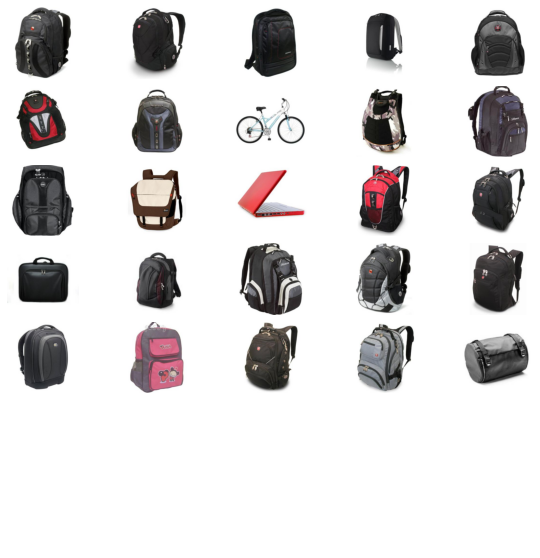

(<Figure size 720x720 with 35 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>]], dtype=object))

In [74]:
query_res = image_search.find_similar_images("./test_cases/backpack1.jpeg",25)
show_grid_images(query_res['image_path'].tolist(),num_rows=7,num_cols=5)

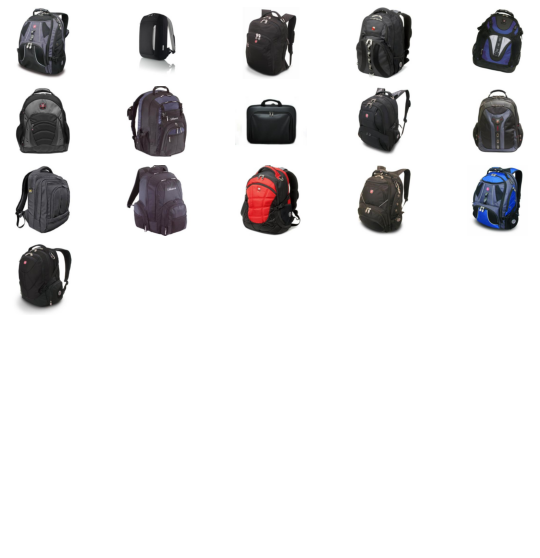

(<Figure size 720x720 with 35 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>]], dtype=object))

In [75]:
query_res = image_search.find_similar_images("./test_cases/backpack2.jpeg",25)
show_grid_images(query_res['image_path'].tolist(),num_rows=7,num_cols=5)

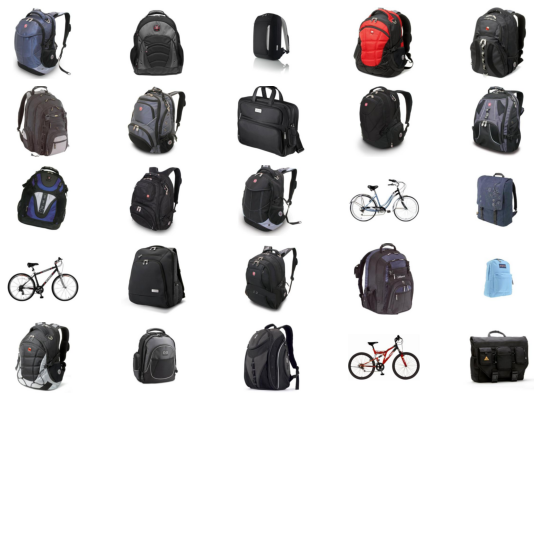

(<Figure size 720x720 with 35 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>]], dtype=object))

In [76]:
query_res = image_search.find_similar_images("./test_cases/backpack3.jpeg",25)
show_grid_images(query_res['image_path'].tolist(),num_rows=7,num_cols=5)

In [81]:
hparams = {
    "num_workers": 2,
    'batch_size': 32,
    "image_size":224,
    "train_test_split":0.1,
}
office_loader = Office31Loader(data_dir="../examples/data/domain_adaptation_images/amazon/images/", hyper_params=hparams)
office_loader.setup('fit')
train_loader = office_loader.train_dataloader()
val_loader = office_loader.val_dataloader()
test_loader = office_loader.test_dataloader()
# /network/projects/aia/img_classif_sim/vit/output/best_model
hparams = {
        "clustering_alg": "MiniBatchKMeans",
        "loss": "CrossEntropyLoss",
        "pretrained": True,
        "batch_size": 32,
        "num_classes": 31,
        "path_to_model": "/network/projects/aia/img_classif_sim/vit/output/best_model/model.ckpt",
        "architecture": "vit",
        "num_clusters": 31,
        "random_state": 0,
        "clustering_batch_size": 124,
        "reassignment_ratio": 0.005,
        "path_cluster_ids": "../debug/dataset_cluster_ids.csv",
    }
image_search = ImageSimilaritySearch(hparams, office_loader)
image_search.setup()

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkp

[MiniBatchKMeans] Reassigning 13 cluster centers.
[MiniBatchKMeans] Reassigning 13 cluster centers.
[MiniBatchKMeans] Reassigning 14 cluster centers.
[MiniBatchKMeans] Reassigning 14 cluster centers.
[MiniBatchKMeans] Reassigning 11 cluster centers.
[MiniBatchKMeans] Reassigning 6 cluster centers.
[MiniBatchKMeans] Reassigning 12 cluster centers.
>>> saved cluster ids to file
>>> setup completed successfully!


In [ ]:
from tqdm import tqdm
scores = []
for reassignment_ratio in tqdm([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2]):
    hparams["reassignment_ratio"] = reassignment_ratio
    image_search = ImageSimilaritySearch(hparams, office_loader)
    image_search.setup()
    labels_true = np.array(image_search.dataset.class_label.to_list())
    labels_pred = image_search.dataset_cluster_ids
    m = get_clustering_metrics(labels_true, labels_pred)
    m["reassignment_ratio"] = reassignment_ratio
    scores.append(m)

In [79]:
vit_score = pd.DataFrame(scores).sort_values(by="reassignment_ratio")
vit_score

,rand_score,adjusted_rand_score,mutual_info_score,reassignment_ratio
0,0.107129,0.107129,1.079419,0.001
1,0.132251,0.132251,1.254756,0.005
2,0.115358,0.115358,1.218413,0.010
3,0.101228,0.101228,0.893497,0.050
4,0.074128,0.074128,0.729688,0.100
5,0.034746,0.034746,0.512689,0.200
6,0.002948,0.002948,0.209706,0.300
7,0.001145,0.001145,0.195858,0.400
8,0.020959,0.020959,0.306992,0.500
9,0.001419,0.001419,0.215344,0.600


<AxesSubplot:xlabel='reassignment_ratio'>

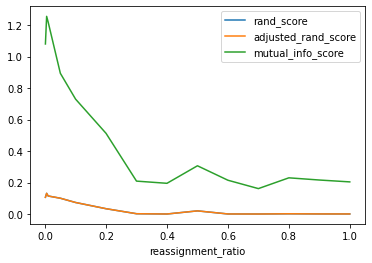

In [80]:
pd.DataFrame(vit_score).sort_values(by="reassignment_ratio").plot(x="reassignment_ratio")


you may need to run this file as a python script to have results printed to file.

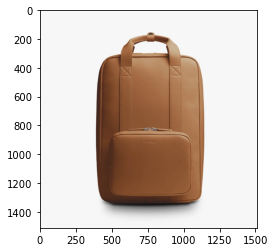

In [31]:
plt.imshow(plt.imread("./test_cases/backpack1.jpeg"))

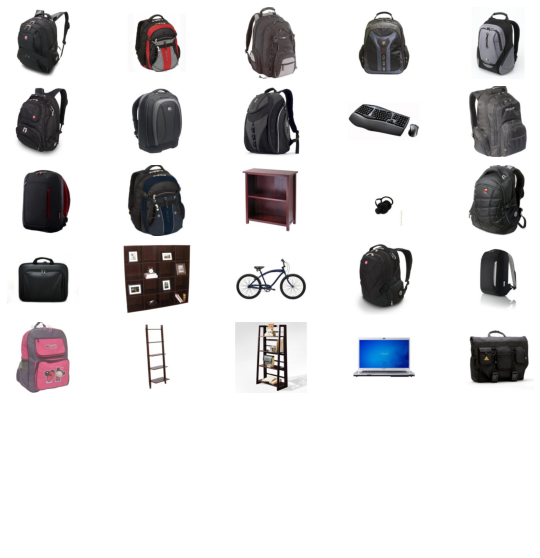

(<Figure size 720x720 with 35 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>]], dtype=object))

In [82]:
query_res = image_search.find_similar_images("./test_cases/backpack1.jpeg",25)
show_grid_images(query_res['image_path'].tolist(),num_rows=7,num_cols=5)

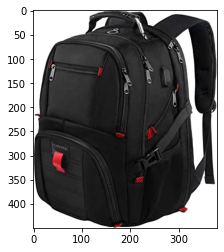

In [30]:
plt.imshow(plt.imread("./test_cases/backpack2.jpeg"))

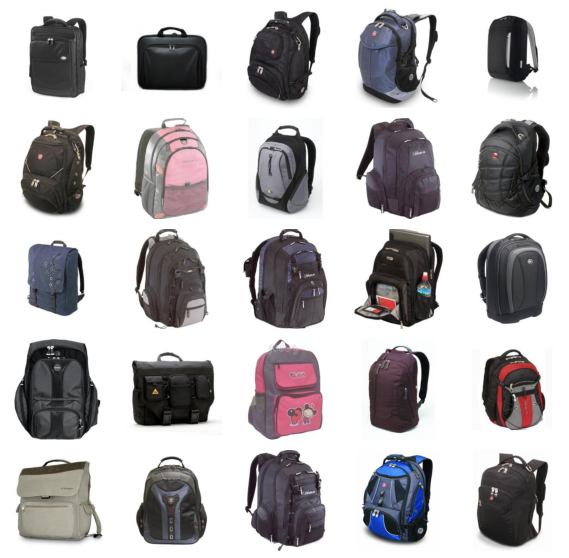

(<Figure size 720x720 with 25 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>]], dtype=object))

In [83]:
query_res = image_search.find_similar_images("./test_cases/backpack2.jpeg",25)
show_grid_images(query_res['image_path'].tolist())


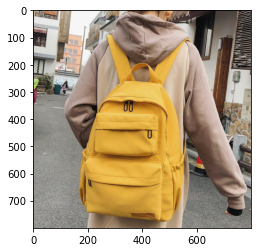

In [32]:
plt.imshow(plt.imread("./test_cases/backpack3.jpeg"))

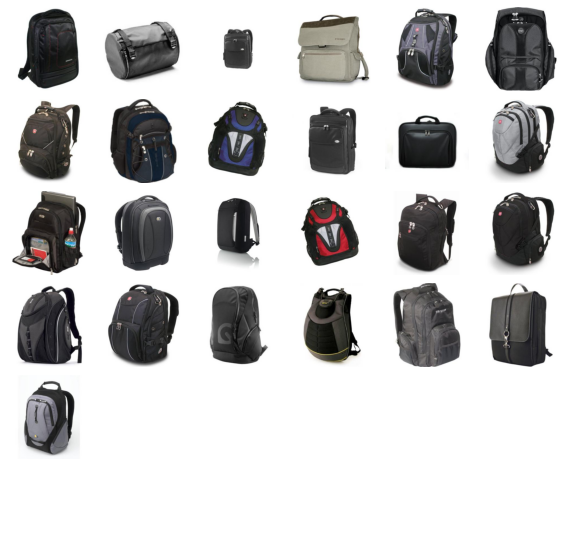

(<Figure size 720x720 with 36 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

In [84]:
query_res = image_search.find_similar_images("./test_cases/backpack3.jpeg",25)
show_grid_images(query_res['image_path'].tolist(),num_rows=6,num_cols=6)


## CNN

In [89]:
hparams = {
    "num_workers": 2,
    'batch_size': 32,
    "image_size":224,
    "train_test_split":0.1,
}
office_loader = Office31Loader(data_dir="../examples/data/domain_adaptation_images/amazon/images/", hyper_params=hparams)
office_loader.setup('fit')
train_loader = office_loader.train_dataloader()
val_loader = office_loader.val_dataloader()
test_loader = office_loader.test_dataloader()

hparams = {
        "clustering_alg": "MiniBatchKMeans",
        "loss": "CrossEntropyLoss",
        "batch_size": 124,
        "num_channels": 3,
        "pretrained": True,
        "num_classes": 31,
        "img_size": 224,
        "path_to_model": "/network/projects/aia/img_classif_sim/classic_cnn/output/best_model/model.ckpt",
        "architecture": "classic-cnn",
        "num_clusters": 31,
        "random_state": 0,
        "clustering_batch_size": 124,
        "reassignment_ratio": 0.02,
        "path_cluster_ids": "../debug/dataset_cluster_ids.csv",
    }
image_search = ImageSimilaritySearch(hparams, office_loader)
image_search.setup()

[MiniBatchKMeans] Reassigning 5 cluster centers.
[MiniBatchKMeans] Reassigning 8 cluster centers.
[MiniBatchKMeans] Reassigning 9 cluster centers.
[MiniBatchKMeans] Reassigning 9 cluster centers.
[MiniBatchKMeans] Reassigning 3 cluster centers.
[MiniBatchKMeans] Reassigning 4 cluster centers.
>>> saved cluster ids to file
>>> setup completed successfully!


In [ ]:
from tqdm import tqdm
scores = []
for reassignment_ratio in tqdm([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
    hparams["reassignment_ratio"] = reassignment_ratio
    image_search = ImageSimilaritySearch(hparams, office_loader)
    image_search.setup()
    labels_true = np.array(image_search.dataset.class_label.to_list())
    labels_pred = image_search.dataset_cluster_ids
    m = get_clustering_metrics(labels_true, labels_pred)
    m["reassignment_ratio"] = reassignment_ratio
    scores.append(m)

In [87]:
cnn_scores = pd.DataFrame(scores).sort_values(by="reassignment_ratio")
cnn_scores

,rand_score,adjusted_rand_score,mutual_info_score,reassignment_ratio
0,0.023217,0.023217,0.426923,0.001
1,0.031893,0.031893,0.503550,0.005
2,0.038015,0.038015,0.535426,0.010
3,0.032441,0.032441,0.512403,0.050
4,0.037356,0.037356,0.510035,0.100
5,0.040185,0.040185,0.531326,0.200
6,0.031631,0.031631,0.411193,0.300
7,0.023035,0.023035,0.354670,0.400
8,0.017941,0.017941,0.339554,0.500
9,0.020235,0.020235,0.384675,0.600


<AxesSubplot:xlabel='reassignment_ratio'>

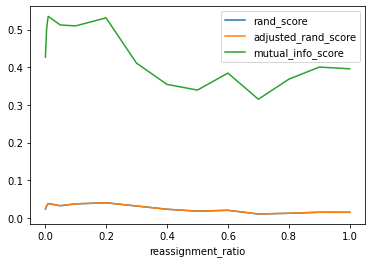

In [88]:
pd.DataFrame(cnn_scores).sort_values(by="reassignment_ratio").plot(x="reassignment_ratio")

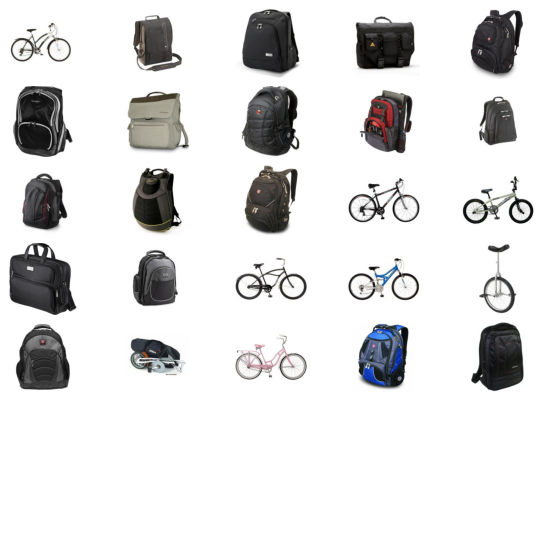

(<Figure size 720x720 with 35 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>]], dtype=object))

In [90]:
query_res = image_search.find_similar_images("./test_cases/backpack1.jpeg",25)
show_grid_images(query_res['image_path'].tolist(),num_rows=7,num_cols=5)

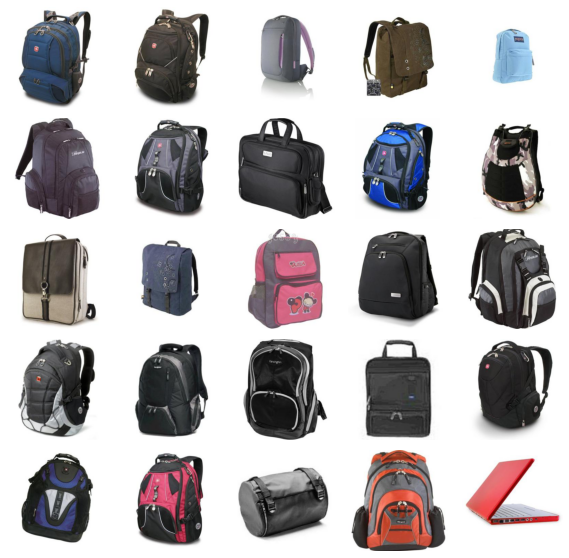

(<Figure size 720x720 with 25 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>]], dtype=object))

In [91]:
query_res = image_search.find_similar_images("./test_cases/backpack2.jpeg",25)
show_grid_images(query_res['image_path'].tolist())


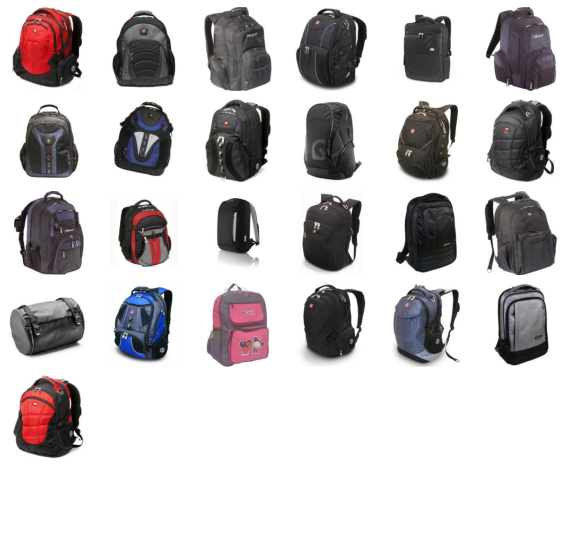

(<Figure size 720x720 with 36 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>, <AxesSubplot:>]], dtype=object))

In [92]:
query_res = image_search.find_similar_images("./test_cases/backpack3.jpeg",25)
show_grid_images(query_res['image_path'].tolist(),num_rows=6,num_cols=6)


In [ ]:
hparams_ae = {
    "clustering_alg": "MiniBatchKMeans",
    "loss": "CrossEntropyLoss",
    "pretrained": True,
    "batch_size": 100,
    "num_channels": 3,
    "num_classes": 31,
    "path_to_model": "/network/projects/aia/img_classif_sim/conv_ae/output/best_model/model.ckpt",
    "architecture": "conv_ae",
    "num_clusters": 32,
    "random_state": 0,
    "clustering_batch_size": 100,
    "reassignment_ratio": 0.01,
    "path_cluster_ids": "../debug/dataset_cluster_ids.csv"
}
image_search = ImageSimilaritySearch(hparams_ae, office_loader)
image_search.setup()

In [ ]:
from tqdm import tqdm
scores = []
for reassignment_ratio in tqdm([0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]):
    hparams["reassignment_ratio"] = reassignment_ratio
    image_search = ImageSimilaritySearch(hparams, office_loader)
    image_search.setup()
    labels_true = np.array(image_search.dataset.class_label.to_list())
    labels_pred = image_search.dataset_cluster_ids
    m = get_clustering_metrics(labels_true, labels_pred)
    m["reassignment_ratio"] = reassignment_ratio
    scores.append(m)

In [97]:
ae_scores = pd.DataFrame(scores).sort_values(by="reassignment_ratio")
ae_scores

,rand_score,adjusted_rand_score,mutual_info_score,reassignment_ratio
0,0.033502,0.033502,0.483926,0.001
1,0.031961,0.031961,0.523788,0.005
2,0.042739,0.042739,0.600988,0.010
3,0.036180,0.036180,0.508057,0.050
4,0.039816,0.039816,0.528097,0.100
5,0.042161,0.042161,0.493012,0.200
6,0.014472,0.014472,0.345970,0.300
7,0.018585,0.018585,0.401371,0.400
8,0.017719,0.017719,0.387077,0.500
9,0.015399,0.015399,0.389301,0.600


<AxesSubplot:xlabel='reassignment_ratio'>

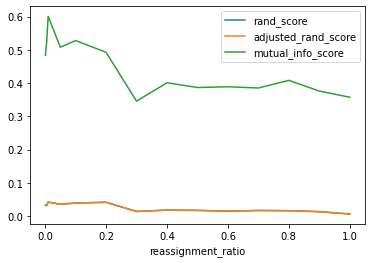

In [98]:
pd.DataFrame(ae_scores).sort_values(by="reassignment_ratio").plot(x="reassignment_ratio")

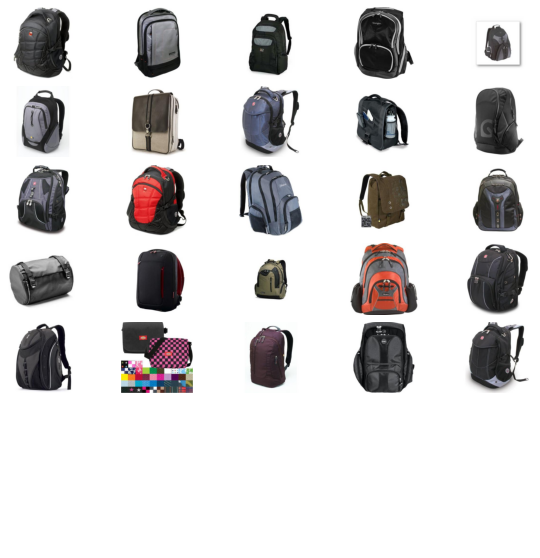

(<Figure size 720x720 with 35 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>]], dtype=object))

In [41]:
query_res = image_search.find_similar_images("./test_cases/backpack1.jpeg",25)
show_grid_images(query_res['image_path'].tolist(),num_rows=7,num_cols=5)

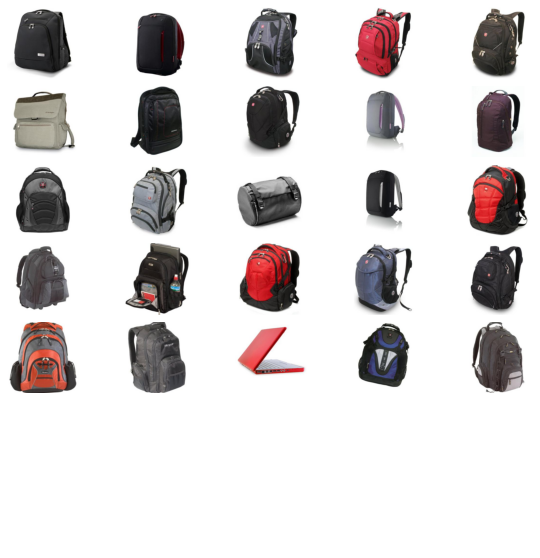

(<Figure size 720x720 with 35 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>]], dtype=object))

In [42]:
query_res = image_search.find_similar_images("./test_cases/backpack2.jpeg",25)
show_grid_images(query_res['image_path'].tolist(),num_rows=7,num_cols=5)

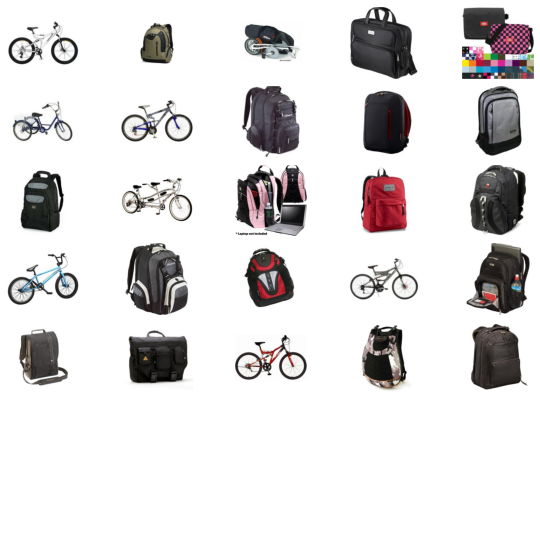

(<Figure size 720x720 with 35 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:>]], dtype=object))

In [43]:
query_res = image_search.find_similar_images("./test_cases/backpack3.jpeg",25)
show_grid_images(query_res['image_path'].tolist(),num_rows=7,num_cols=5)